# EXO 2

In [1]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import matplotlib.pyplot as py
import cmbdb as cmb
from fgbuster import *
from fgbuster.mixingmatrix import MixingMatrix

In [2]:
# a = u.uK_RJ.to(u.uk_CMB)
uK_RJ2uK_CMB = 1* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(300.0 * u.GHz))
print(uK_RJ2uK_CMB)

6.983704969016967


# Simulating Sky

In [3]:
NSIDE = 64
lmax = 3*NSIDE-1
print(lmax)
sky_CMB = get_sky(NSIDE,'c1') 
sky_d0s0 = get_sky(NSIDE, 'd0s0') 
instrument = get_instrument('LiteBIRD')
freq_maps_CMB = get_observation(instrument, sky_CMB)* np.sqrt(uK_RJ2uK_CMB)
freq_maps_d0s0 = get_observation(instrument,sky_d0s0)

num_freq,ncomp,npix = freq_maps_d0s0.shape


191


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
# map_CMB_input = freq_maps_CMB[0]
# cl_CMB_input = hp.anafast(map_CMB_input)
# print(cl_CMB_input.shape)

In [5]:
cl_CMB_th = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_lensed_scalar.fits")
print(cl_CMB_th.shape)
cl_CMB_crop_th = cl_CMB_th[:,:lmax+1]
print(cl_CMB_crop_th.shape)

map_CMB = hp.synfast(cl_CMB_th,nside=NSIDE,new = True)
# map_CMB = freq_maps_CMB[0]
# print(map_CMB.shape)
cl_CMB6 = hp.anafast(map_CMB,lmax=lmax,alm = False)
cl_CMB = cl_CMB6[:4]
print(cl_CMB.shape)
map_CMB_QU = np.zeros((2,npix),dtype=complex)
map_CMB_QU[0] = map_CMB[1]  # Q
map_CMB_QU[1] = map_CMB[2]  # Q
print(map_CMB_QU.shape)

(4, 4001)
(4, 192)
(4, 192)
(2, 49152)


In [6]:
freq_maps_simple_noiseless = np.array([np.add(map_CMB,maps_d0s0) for maps_d0s0 in freq_maps_d0s0])
freq_map_noise = get_noise_realization(nside=NSIDE,instrument=instrument#,unit = 'uK_CMB'
                                       )
freq_maps_simple = np.add(freq_map_noise,freq_maps_simple_noiseless)

print(freq_maps_simple.shape)
freq_maps_simple_QU = np.zeros((num_freq,2,npix))
for i in range(0,num_freq):
    freq_maps_simple_QU[i][0]=freq_maps_simple[i][1]   
    freq_maps_simple_QU[i][1]=freq_maps_simple[i][2]
print(freq_maps_simple_QU.shape)
amin2rad = np.pi/(60.*180.)

(15, 3, 49152)
(15, 2, 49152)


In [7]:
fwhm = instrument.fwhm*amin2rad
freq = instrument.frequency
print(instrument.fwhm)

0     70.5
1     58.5
2     51.1
3     47.1
4     43.8
5     41.5
6     37.8
7     33.6
8     30.8
9     28.9
10    28.6
11    24.7
12    22.5
13    20.9
14    17.9
Name: fwhm, dtype: float64


## Beam (check with hp.smoothing)

In [8]:
beam_array = np.array([hp.gauss_beam(f,lmax,pol=True) for f in fwhm])
print(beam_array.shape)

(15, 192, 4)


In [9]:
AS_lm = np.array([hp.map2alm(map_simple) for map_simple in freq_maps_simple_noiseless]) ##with noise

AS_lm.shape
print(AS_lm.shape)

(15, 3, 18528)


In [10]:
BAS_lm_T =np.array([hp.almxfl(AS_lm[i][0],beam_array[i,:,0]) for i in range(0,num_freq)])
BAS_lm_E =np.array([hp.almxfl(AS_lm[i][1],beam_array[i,:,1]) for i in range(0,num_freq)])
BAS_lm_B =np.array([hp.almxfl(AS_lm[i][2],beam_array[i,:,2]) for i in range(0,num_freq)])
nf,nlm = BAS_lm_B.shape
BAS_lm = np.zeros((nf,3,nlm),dtype=complex)
for i in range(0,nf):
    BAS_lm[i,0]=BAS_lm_T[i,:]
    BAS_lm[i,1]=BAS_lm_E[i,:]
    BAS_lm[i,2]=BAS_lm_B[i,:]
print(BAS_lm.shape)




(15, 3, 18528)


In [11]:
BAS_p_nl =np.array([hp.alm2map(BAS_lm[i],nside=NSIDE) for i in range(0,nf)]) #noise
print(BAS_p_nl.shape)
BAS_p = np.add(BAS_p_nl,freq_map_noise)


(15, 3, 49152)


In [12]:
BAS_p_nl_smooth = np.array([hp.smoothing(freq_maps_simple[i],fwhm[i]) for i in range(0,num_freq)])
print(BAS_p_nl_smooth.shape)

(15, 3, 49152)


In [13]:
BAS_QU_p = np.zeros((nf,2,npix))
BAS_QU_p[:,0,:]=BAS_p[:,1,:]
BAS_QU_p[:,1,:]=BAS_p[:,2,:]
print(BAS_QU_p.shape)

(15, 2, 49152)


## Component separation

In [14]:
components = [CMB(), Dust(353.), Synchrotron(23.)]

In [15]:
# The starting point of the fit is the ax1sm default value, so let's shift it
components[1].defaults = [1.54, 20.]
components[2].defaults = [-3.0]

In [16]:
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
i_cmb = A.components.index('CMB')

In [17]:

result_beam_noisy= basic_comp_sep(components, instrument, BAS_QU_p, # verbose output                        
                       )
print(result_beam_noisy.s.shape)

A_beam_noise = A_ev(result_beam_noisy.x)

print(A_beam_noise.shape)
result_no_beam_noisy = basic_comp_sep(components, instrument, freq_maps_simple_QU, # verbose output             
                               )
A_no_beam_noise = A_ev(result_no_beam_noisy.x)

print(A_no_beam_noise.shape)

(3, 2, 49152)
(15, 3)
(15, 3)


### Add noise

In [18]:
def _get_Cl_noise_nofwhm(instrument, A, lmax):
    bl = np.ones((len(instrument.frequency), lmax+1))
    nl = (bl / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2
    AtNA = np.einsum('fi, fl, fj -> lij', A, nl, A)
    inv_AtNA = np.linalg.inv(AtNA)
    return inv_AtNA.swapaxes(-3, -1)

In [19]:
cl_beam_noise =_get_Cl_noise_nofwhm(instrument=instrument,A = A_beam_noise,lmax=lmax)[i_cmb, i_cmb, :]
cl_no_beam_noise =_get_Cl_noise_nofwhm(instrument=instrument,A = A_no_beam_noise,lmax=lmax)[i_cmb, i_cmb, :]
print(cl_beam_noise.shape)
# cl_CMB_BB_bn = cl_beam_noise[0,2,:]
# cl_CMB_BB_nbn = cl_no_beam_noise[0,2,:]

# print(cl_CMB_BB_bn.shape, cl_CMB_BB_nbn.shape)

(192,)


/tmp/ipykernel_407/3811725195.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (bl / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


In [20]:
inputs = [sky_d0s0.components[0].mbb_index,
          sky_d0s0.components[0].mbb_temperature.value,
          sky_d0s0.components[1].pl_index]

for param, val, ref in zip(result_beam_noisy.params, result_beam_noisy.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_no_beam_noisy.params, result_no_beam_noisy.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

Dust.beta_d         	1.540273	1.540000
Dust.temp           	20.094728	20.000000
Synchrotron.beta_pl 	-2.987975	-3.000000
                    	Estimated	Input
Dust.beta_d         	1.540135	1.540000
Dust.temp           	19.997022	20.000000
Synchrotron.beta_pl 	-3.000323	-3.000000


In [35]:
print(result_beam_noisy.s.shape)

(3, 2, 49152)


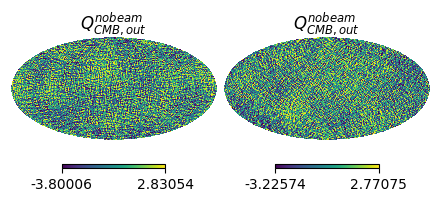

In [38]:
# hp.mollview(result_beam_noisy.s[0,0], title='$Q_{CMB,out}^{beam}$', norm='hist', sub=(1,3,2))
# hp.mollview(result_beam_noisy.s[0,1], title='$U_{CMB,out}^{beam}$', norm='hist', sub=(1,3,3))
hp.mollview(result_no_beam_noisy.s[0,0], title='$Q_{CMB,out}^{no beam}$', norm='hist', sub=(1,3,2))
hp.mollview(result_no_beam_noisy.s[0,1], title='$Q_{CMB,out}^{no beam}$', norm='hist', sub=(1,3,3))

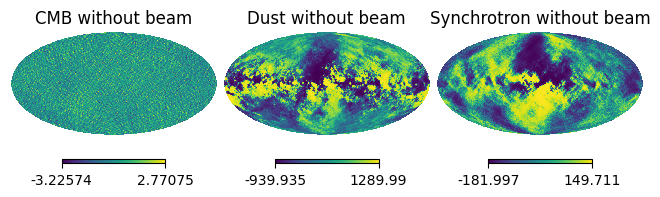

In [34]:
# hp.mollview(result_beam_noisy.s[0,1], title='CMB with beam', sub=(1,3,1))
# hp.mollview(result_beam_noisy.s[1,1], title='Dust with beam', norm='hist', sub=(1,3,2))
# hp.mollview(result_beam_noisy.s[2,1], title='Synchrotron with beam', norm='hist', sub=(1,3,3))
# hp.mollview(result_no_beam_noisy.s[0,1], title='CMB without beam', sub=(1,3,1))
# hp.mollview(result_no_beam_noisy.s[1,1], title='Dust without beam', norm='hist', sub=(1,3,2))
# hp.mollview(result_no_beam_noisy.s[2,1], title='Synchrotron without beam', norm='hist', sub=(1,3,3))

# Residuals

In [22]:
res_CMB_Q_th_beam = np.subtract(result_beam_noisy.s[0,0], map_CMB_QU[0])#noisy
res_CMB_U_th_beam = np.subtract(result_beam_noisy.s[0,1], map_CMB_QU[1])
res_CMB_Q_th_no_beam = np.subtract(result_no_beam_noisy.s[0,0], map_CMB_QU[0])
res_CMB_U_th_no_beam = np.subtract(result_no_beam_noisy.s[0,1], map_CMB_QU[1])
print(res_CMB_Q_th_beam.shape,res_CMB_U_th_beam.shape)

(49152,) (49152,)


In [23]:
res_CMB_beam = np.zeros((3,npix),dtype=complex)
res_CMB_beam[1] = res_CMB_Q_th_beam
res_CMB_beam[2] = res_CMB_U_th_beam
print(res_CMB_beam.shape)

(3, 49152)


In [24]:
res_CMB_no_beam = np.zeros((3,npix),dtype=complex)
res_CMB_no_beam[1] = res_CMB_Q_th_no_beam
res_CMB_no_beam[2] = res_CMB_U_th_no_beam
print(res_CMB_no_beam.shape)

(3, 49152)


In [25]:
C_l_CMB_beam =hp.anafast(res_CMB_beam,lmax = lmax,alm=False,pol=True)
C_l_CMB_no_beam =hp.anafast(res_CMB_no_beam,lmax=lmax,alm=False,pol=True)
print(C_l_CMB_beam.shape)

(6, 192)


/home/julientang2001/.local/lib/python3.10/site-packages/healpy/sphtfunc.py:274: ComplexWarning: Casting complex values to real discards the imaginary part
  alms = _sphtools.map2alm(


In [26]:
C_EE_CMB_beam_l = C_l_CMB_beam[1]
C_BB_CMB_beam_l = C_l_CMB_beam[2]
C_EE_CMB_no_beam_l = C_l_CMB_no_beam[1]
C_BB_CMB_no_beam_l = C_l_CMB_no_beam[2]
print(C_EE_CMB_beam_l.shape)
print(C_BB_CMB_beam_l.shape)

(192,)
(192,)


### Retrieved CMB Power spectrum

In [27]:
res_ret_nb = np.zeros((3,npix),dtype=complex)
res_ret_nb[1] = result_no_beam_noisy.s[0,0]
res_ret_nb[2] = result_no_beam_noisy.s[0,1]
print(res_ret_nb.shape)
res_ret_b = np.zeros((3,npix),dtype=complex)
res_ret_b[1] = result_beam_noisy.s[0,0]
res_ret_b[2] = result_beam_noisy.s[0,1]


(3, 49152)


In [28]:
C_L_ret_nb = hp.anafast(res_ret_nb,alm = False,pol=True)
print(C_L_ret_nb.shape)
C_l_ret_nb_BB = C_L_ret_nb[2]
print(C_l_ret_nb_BB.shape)
C_L_ret_b = hp.anafast(res_ret_b,alm = False,pol=True)
print(C_L_ret_b.shape)
C_l_ret_b_BB = C_L_ret_b[2]
print(C_l_ret_b_BB.shape)

(6, 192)
(192,)
(6, 192)
(192,)


# + Gravitational waves

In [29]:
cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

map_CMB = hp.synfast(cl_GW,nside=NSIDE)

(4, 4101)
(4, 192)


In [30]:
cl_tot_th = np.add(0.001*cl_GW_crop,cl_CMB)

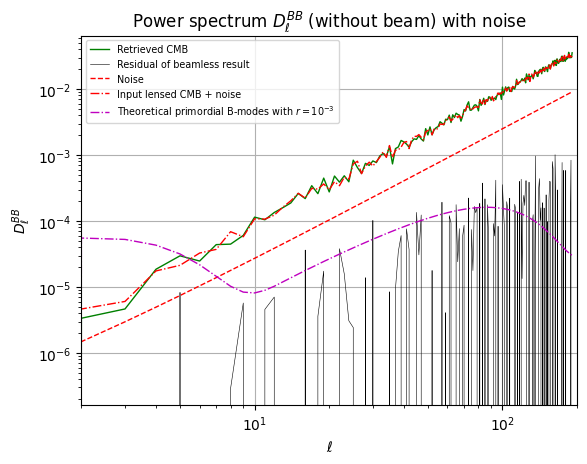

In [31]:
# py.figure(1)

l_arr = np.arange(0,lmax+1,1)
# ax1 = py.subplot(211)

# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_EE_CMB_beam_l,'r',label = 'with beam')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_EE_CMB_no_beam_l,'b',label = 'without beam')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_CMB[1],label = "$D_{\ell,lens}^{EE}$")
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[1],label = "$D_{\ell,GW}^{EE}$")

# handles, labels = ax1.get_legend_handles_labels()
# #py.legend(handles, labels)

# py.grid()
# py.tick_params('x', labelbottom=False)
# py.ylabel('$D_{\ell}^{EE}$')
# py.yscale("log")
# py.xscale("log")

# py.title('Power spectra of the residuals $D_{\ell}^{BB}$ of the residuals with and without beam')

# py = py.subplot(212,sharex = ax1)
py.figure(1)
ax1 = py.subplot(111)
# ax1.tick_params('x', labelsize=6)
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*np.subtract(C_BB_CMB_beam_l,cl_beam_noise),'k',linewidth =.4,label = 'Residual of result with beam')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_l_ret_b_BB,'g',linewidth = 1,label = 'Retrieved CMB')

# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_beam_noise,'r--',linewidth =1, label = 'Noise')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*np.add(cl_CMB[2],cl_beam_noise),'r-.',linewidth =1,label = "Input lensed CMB + noise")
# py.title('Power spectrum $D_{\ell}^{BB}$ (with beam) with noise')

ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_l_ret_nb_BB,'g',linewidth = 1,label = 'Retrieved CMB')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*np.subtract(C_BB_CMB_no_beam_l,cl_no_beam_noise),'k',linewidth =.4,label = 'Residual of beamless result')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_no_beam_noise,'r--',linewidth =1, label = 'Noise')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*np.add(cl_CMB[2],cl_no_beam_noise),'r-.',linewidth =1,label = "Input lensed CMB + noise")

py.title('Power spectrum $D_{\ell}^{BB}$ (without beam) with noise')
         #of the residuals with and without beam, with noise')

# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*np.add(cl_CMB_crop_th[2],0),'b-.',linewidth =1,label = "Theoretical lensed CMB ")

        #  $D_{\ell,lens}^{BB}$")
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")
        # $D_{\ell,GW}^{BB}$")

handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2)
py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")



py.ylabel('$D_{\ell}^{BB}$')
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

In [32]:
rapport = cl_CMB[2]/cl_CMB_crop_th[2]
print(rapport.shape)
rapport = rapport[2:]
print(np.sum(rapport)/len(rapport))

(192,)
0.998491858312151


/tmp/ipykernel_407/362470105.py:1: RuntimeWarning: invalid value encountered in divide
  rapport = cl_CMB[2]/cl_CMB_crop_th[2]
